In [1]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

from sklearn.metrics import  mean_absolute_percentage_error, mean_absolute_error

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/StockData/VCB-Historical-Data.csv',index_col=0,parse_dates=True).sort_values(by='Date',ascending=True)
df['Price']=df['Price'].replace(',','',regex=True).astype(float)

df = df.rename(columns={'Price': 'Close'})
df.head()


,Close,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-02,41161.0,"41,391","41,698","41,084",1.38M,0.19%
2019-01-03,41161.0,"41,468","41,545","40,470",1.37M,0.00%
2019-01-04,41775.0,"40,931","41,775","40,393",1.67M,1.49%
2019-01-07,41929.0,"42,466","42,620","41,852",1.50M,0.37%
2019-01-08,42236.0,"42,236","42,390","41,852",1.68M,0.73%


In [3]:
df1 = df[['Close']]
df1

,Close
Date,
2019-01-02,41161.0
2019-01-03,41161.0
2019-01-04,41775.0
2019-01-07,41929.0
2019-01-08,42236.0
...,...
2023-05-26,92000.0
2023-05-29,93100.0
2023-05-30,94500.0


In [4]:
# 3. Scaler data
scaler=MinMaxScaler()
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [5]:
# 4. Chia train test val theo tỉ lệ 8-1-1
train_size = int(0.8 * len(df1))
test_size = int(0.1 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [6]:
# 5. Hàm Create Dataset
#window sliding
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+39 and Y=t+40
time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=40,verbose=1)

Epoch 1/100
21/21 [==============================] - 9s 163ms/step - loss: 0.0701 - val_loss: 0.0118
Epoch 2/100
21/21 [==============================] - 1s 45ms/step - loss: 0.0066 - val_loss: 0.0039
Epoch 3/100
21/21 [==============================] - 1s 45ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 4/100
21/21 [==============================] - 1s 47ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 5/100
21/21 [==============================] - 1s 49ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 6/100
21/21 [==============================] - 1s 48ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 7/100
21/21 [==============================] - 1s 69ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 8/100
21/21 [==============================] - 1s 51ms/step - loss: 9.5949e-04 - val_loss: 0.0019
Epoch 9/100
21/21 [==============================] - 1s 43ms/step - loss: 9.1229e-04 - val_loss: 0.0019
Epoch 10/100
21/21 [==============================] - 1s 48ms/step - loss: 8.8283e-04 - val

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)


3/3 [==============================] - 0s 9ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
original_ytest = scaler.inverse_transform(ytest.reshape(-1,1)) 
original_yval = scaler.inverse_transform(yval.reshape(-1,1)) 

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - original_yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - original_ytest)**2))
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")

Validation RMSE: 1184.95
Testing RMSE: 1752.02


In [14]:
# 13. Đánh giá độ chính xác thuật toán bằng MAE
valid_mae = mean_absolute_error(original_yval, y_pred_val)
test_mae = mean_absolute_error(original_ytest, y_pred)
print(f"Validation MAE: {valid_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")

Validation MAE: 887.93
Testing MAE: 1323.73


In [15]:
# 14. Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = mean_absolute_percentage_error(original_yval, y_pred_val)
test_mape = mean_absolute_percentage_error(original_ytest,y_pred)
print(f"Validation MAPE: {valid_mape* 100:.2f}%")
print(f"Testing MAPE: {test_mape*100:.2f}%")

Validation MAPE: 0.98%
Testing MAPE: 1.80%


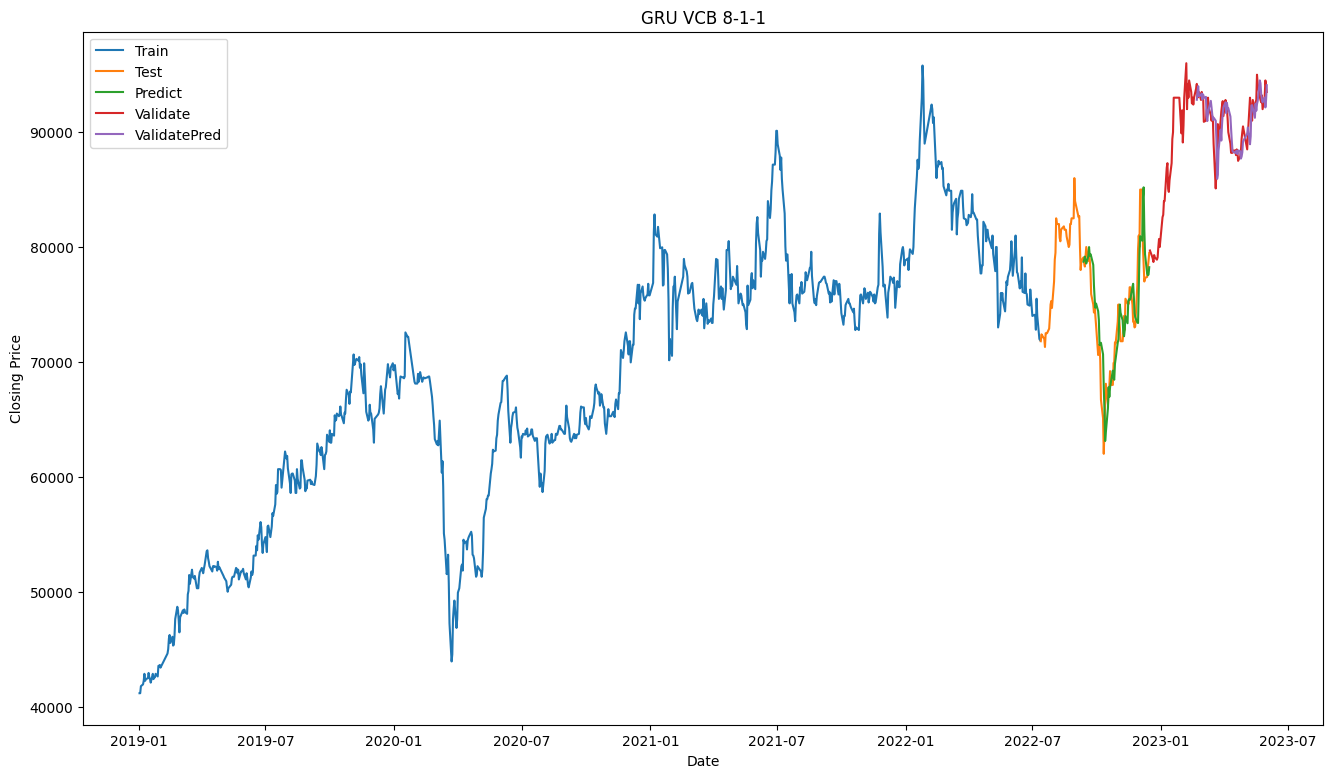

In [16]:
# 14.Vẽ hình
plt.figure(figsize=(16,9))
plt.ylabel('Closing Price');
plt.xlabel('Date');
plt.title('GRU VCB 8-1-1')
train_index = df[:train_size].index
plt.plot(train_index,scaler.inverse_transform(train_data))
#test
test_index = df[train_size:train_size+test_size].index
plt.plot(test_index,scaler.inverse_transform(test_data))
#test predict
test_predict_index = df[train_size+41:train_size+test_size].index
plt.plot(test_predict_index,(y_pred))
#val
val_index = df[train_size+test_size:train_size+test_size+val_size].index
plt.plot(val_index,scaler.inverse_transform(val_data))
#val predict
val_predict_index = df[train_size+test_size+41:train_size+test_size+val_size].index
plt.plot(val_predict_index,y_pred_val)
#prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
#plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred'])
plt.show()